In [ ]:
# !pip install ucimlrepo

### **Load the Dataset**

In [5]:
from ucimlrepo import fetch_ucirepo


breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)
X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets


print(breast_cancer_wisconsin_diagnostic.metadata)
print(breast_cancer_wisconsin_diagnostic.variables)


{'uci_id': 17, 'name': 'Breast Cancer Wisconsin (Diagnostic)', 'repository_url': 'https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic', 'data_url': 'https://archive.ics.uci.edu/static/public/17/data.csv', 'abstract': 'Diagnostic Wisconsin Breast Cancer Database.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 569, 'num_features': 30, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Diagnosis'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1993, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5DW2B', 'creators': ['William Wolberg', 'Olvi Mangasarian', 'Nick Street', 'W. Street'], 'intro_paper': {'ID': 230, 'type': 'NATIVE', 'title': 'Nuclear feature extraction for breast tumor diagnosis', 'authors': 'W. Street, W. Wolberg, O. Mangasarian', 'venue': 'Electronic imaging', 'year': 1993, 'journal': None, 'DOI': '1

### **Data Preprocessing**

In [6]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import numpy as np


# Encode labels
le = LabelEncoder()
y = le.fit_transform(y)
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert to PyTorch tensors

X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### **Define Neural Network**

In [7]:
class BreastCancerNN(nn.Module):
    def __init__(self):
        super(BreastCancerNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(X.shape[1], 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

model = BreastCancerNN()

### **Loss and Ooptimizer**

In [8]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

###  **Training Loop**

In [10]:
num_epochs = 50
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):
    # Training
    model.train()
    epoch_train_loss = 0
    correct, total = 0, 0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct += (preds == yb).sum().item()
        total += yb.size(0)

    train_losses.append(epoch_train_loss / len(train_loader))
    train_accs.append(correct / total)

    # Validation
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            outputs = model(xb)
            loss = criterion(outputs, yb)
            val_loss += loss.item()
            preds = (outputs > 0.5).float()
            correct += (preds == yb).sum().item()
            total += yb.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accs.append(correct / total)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, "
          f"Train Acc: {train_accs[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}")

Epoch 1/50, Train Loss: 0.6158, Val Loss: 0.5428, Train Acc: 0.8286, Val Acc: 0.8860
Epoch 2/50, Train Loss: 0.4535, Val Loss: 0.3693, Train Acc: 0.9363, Val Acc: 0.9123
Epoch 3/50, Train Loss: 0.2917, Val Loss: 0.2292, Train Acc: 0.9516, Val Acc: 0.9211
Epoch 4/50, Train Loss: 0.1792, Val Loss: 0.1576, Train Acc: 0.9516, Val Acc: 0.9211
Epoch 5/50, Train Loss: 0.1301, Val Loss: 0.1218, Train Acc: 0.9604, Val Acc: 0.9737
Epoch 6/50, Train Loss: 0.1145, Val Loss: 0.1030, Train Acc: 0.9736, Val Acc: 0.9649
Epoch 7/50, Train Loss: 0.0866, Val Loss: 0.0906, Train Acc: 0.9714, Val Acc: 0.9649
Epoch 8/50, Train Loss: 0.0847, Val Loss: 0.0847, Train Acc: 0.9714, Val Acc: 0.9649
Epoch 9/50, Train Loss: 0.0812, Val Loss: 0.0807, Train Acc: 0.9824, Val Acc: 0.9649
Epoch 10/50, Train Loss: 0.0719, Val Loss: 0.0744, Train Acc: 0.9802, Val Acc: 0.9737
Epoch 11/50, Train Loss: 0.0622, Val Loss: 0.0729, Train Acc: 0.9824, Val Acc: 0.9737
Epoch 12/50, Train Loss: 0.0589, Val Loss: 0.0705, Train Acc: 0

### **Evaluation (F1-Score)**

In [11]:
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for xb, yb in val_loader:
        outputs = model(xb)
        preds = (outputs > 0.5).float()
        y_true.extend(yb.numpy())
        y_pred.extend(preds.numpy())

print("Validation Accuracy:", accuracy_score(y_true, y_pred))
print("Validation F1-score:", f1_score(y_true, y_pred))

Validation Accuracy: 0.9736842105263158
Validation F1-score: 0.963855421686747


### **Plot Loss and Accuracy**

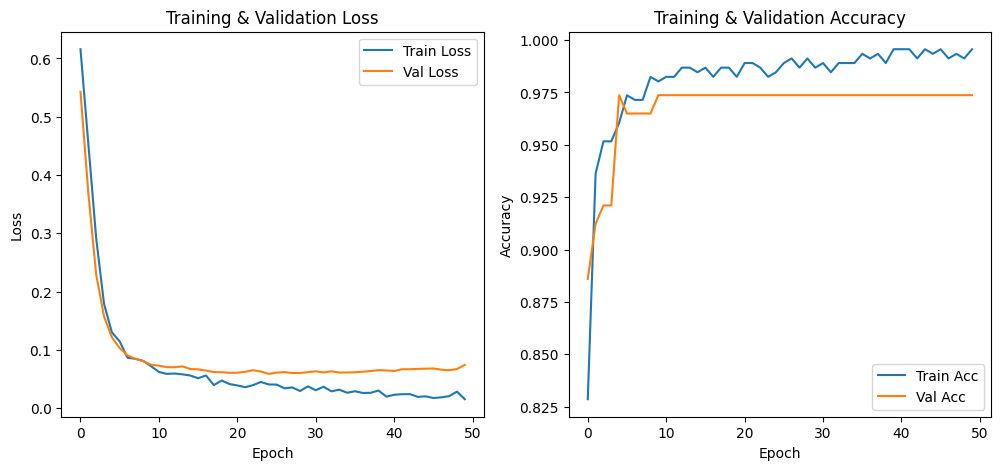

In [12]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()

plt.show()